# **Import Libraries**

In [1]:
import cv2
import dlib
import numpy as np
from PIL import Image

import glob
from IPython.display import display

# **Exctract facial features & Normalize images**

In [27]:
# Note that OpenCV uses BGR color format
RED = (0, 0, 255)
GREEN = (0, 255, 0)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

IMG_DIM = 600
LEFT_EYE_CORNER = 36
RIGHT_EYE_CORNER = 45
BOTTOM_LIP = 57


def convertDisplay(img):
    """
    Convert BGR -> RGB -> PIL, then display the image in jupyter notebook

    Args:
      img (ndarray (width, height, 3)): Image
      
    Returns
        None: Displays image
    """
    # Convert to RGB, then to PIL
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_img)

    # Use display(pil_img) to display in jupyter or use pil_img.show()
    display(pil_img)


def detectFace(img):
    """
    Detect the face present in the image. If the image contains two or more faces, only return the largest face.  
    
    Args:
      img (ndarray (width, height, 3)): Image
      
    Returns
        face (dlib_rectangles): Rectangle that delimits the face
    """
    face = detector(img, 1)

    if len(face) == 0:
        return None
    elif len(face) == 1:
        return face[0]
    else:
        return max(faces, key=lambda rect: rect.width()*rect.height())


def normalizeImage(img, landmarks):
    """
    Warps the image input to a 600x600 image with the aid of the outer corner of the eyes and the bottom lip 
    
    Args:
      img (ndarray (width, height, 3)): Image
      landmarks (dlib_full_object_detection (68)): Facial landmarks of the image
      
    Returns
        (normalized_img, updated_landmarks) (ndarray (600, 600, 3), ndarray (68, 2)): Warped 600x600 image
                                                                                        and landmarks for the warped image
    """
    left_eye = landmarks.part(LEFT_EYE_CORNER)
    right_eye = landmarks.part(RIGHT_EYE_CORNER)
    bot_lip = landmarks.part(BOTTOM_LIP)

    # Create source array with float32 type
    src = np.array([[left_eye.x, left_eye.y],
                    [right_eye.x, right_eye.y],
                    [bot_lip.x, bot_lip.y]], dtype=np.float32)
    
    # Create destination array with float32 type
    dst = np.array([[180, 200],
                    [420, 200],
                    [300, 400]], dtype=np.float32)

    # Get transformation matrix
    T = cv2.getAffineTransform(src, dst)

    # Warp Image
    normalized_img = cv2.warpAffine(img, T, (IMG_DIM,IMG_DIM))

    # Update landmarks (T*landmarks + translation), but first convert to ndarray
    npLandmarks = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)], dtype=np.float32)
    last_row = T[:, -1]
    translation = np.array([last_row for _ in range(68)], dtype=np.float32)
    
    updated_landmarks = (np.delete(T, -1, axis=1) @ npLandmarks.transpose()).transpose() + translation

    return (normalized_img, updated_landmarks.astype(int))


def drawLandmarksDisplay(img_lst, radius):
    """
    Display on screen the images with it's landmarks drawn on it
    
    Args:
      img_lst (img, landmarks):
          img (ndarray (width, height, 3)): Image
          landmarks (dlib_full_object_detection (68)): Facial landmarks of the image
      radius (int): Radius of the circle drawn for each landmark

    Returns
        None: Displays images
    """
    for img, landmarks in img_lst:
        # Draw a circle for each landmark
        for x, y in landmarks:
            cv2.circle(img, (x, y), radius, GREEN, -1)

        #convertDisplay(img)


def drawDelaunayTrianglesDisplay(img, delaunay_triangles):
    """
    Draws the delaunay triangles on the image and displays it
    
    Args:
      img (ndarray (width, height, 3)): Image
      delaunay_triangles (num_triangles, 6): Array with triangles (3 points (2 coordinates each))
      
    Returns
        None: Displays image
    """
    for t in delaunay_triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        # Draw triangle
        cv2.line(img, pt1, pt2, RED)
        cv2.line(img, pt2, pt3, RED)
        cv2.line(img, pt3, pt1, RED)

    convertDisplay(img)

In [17]:
images_path = glob.glob("images/*")
normalized_imgs = []

for img_path in images_path:
    img = cv2.imread(img_path)
    face = detectFace(img)

    if face is None:
        print("Error: Couldn't detect any faces in:", img_path)
    else:
        print("Loading:", img_path)

        landmarks = predictor(img, face)
        normalized_img, landmarks = normalizeImage(img, landmarks)

        # Add more points to landmarks to help with alignment later on
        landmarks = np.vstack((landmarks,  [[0, 0],
                                            [300, 0],
                                            [600-1, 0],
                                            [0, 300],
                                            [600-1, 300],
                                            [0, 600-1],
                                            [300, 600-1],
                                            [600-1, 600-1]]))

        normalized_imgs.append((normalized_img, landmarks))

print("Done")

Loading: images/Donald_Trump.webp
Loading: images/Elon_Musk.webp
Loading: images/Mark_Zuckerberg.webp
Done


In [18]:
# Run this code to display the normalized images with facial features

# drawLandmarks(normalized_imgs, 2)

# **Delaunay Triangulation**

In [19]:
# Average Landmarks
avg_points = (sum([landmarks for img, landmarks in normalized_imgs]) / len(normalized_imgs))

# Planar subdivision of the final image
img_rect = (0, 0, IMG_DIM, IMG_DIM)
subdiv = cv2.Subdiv2D(img_rect)

for point in avg_points:
    subdiv.insert(point)

delaunay_triangles = subdiv.getTriangleList().astype(int)
avg_points = avg_points.astype(int)

delaunay_indices = []

for t in delaunay_triangles:
    pts = [(t[0], t[1]), (t[2], t[3]), (t[4], t[5])]

    # Extract indices
    indices = [np.where((avg_points == p).all(axis=1))[0][0] for p in pts]
    delaunay_indices.append(indices)

In [20]:
# Run this code to display the final delaunay triangles on each image

for img, landmarks in normalized_imgs:
    # drawDelaunayTrianglesDisplay(img, delaunay_triangles)
    pass

# **Align images**

In [21]:
warped_imgs = []

for img, landmarks in normalized_imgs:
    landmarks = landmarks.astype(np.float32)

    # Extract corresponding triangles
    triangles_src = np.array([[landmarks[i] for i in triangle] for triangle in delaunay_indices], dtype=np.float32)
    triangles_dst = np.array([[avg_points[i] for i in triangle] for triangle in delaunay_indices], dtype=np.float32)

    warped_img = np.zeros((IMG_DIM, IMG_DIM, 3), dtype=img.dtype)

    for src, dst in zip(triangles_src, triangles_dst):
        # Get the affine transform
        T = cv2.getAffineTransform(src, dst)

        # Create a mask for the triangle in the destination image
        mask = np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst), 255)

        # Warp the triangle
        warped_triangle = cv2.warpAffine(img, T, (IMG_DIM, IMG_DIM), borderMode=cv2.BORDER_REFLECT_101)

        # Blend the warped triangle into the final image
        warped_img[mask == 255] = warped_triangle[mask == 255]

    warped_imgs.append(warped_img)

In [22]:
# Run this code to display the warped images

for img in warped_imgs:
    # convertDisplay(img)
    pass

# **Generate Average Face**

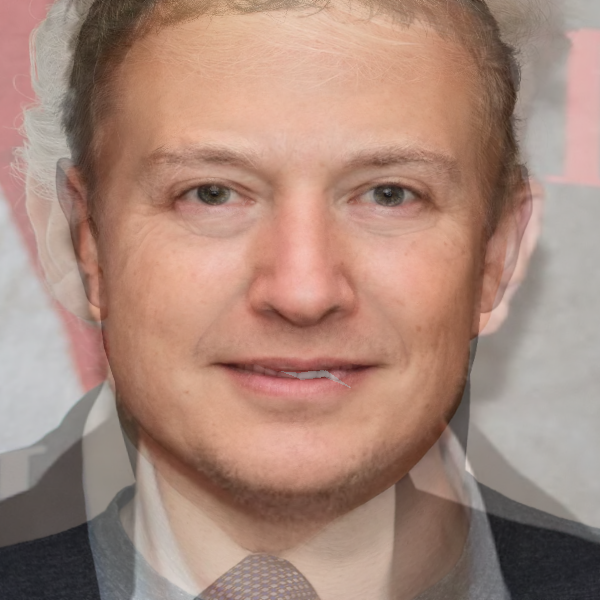

In [26]:
final_img = np.round(np.mean(np.array(warped_imgs), axis=0)).astype(np.uint8)

convertDisplay(final_img)